In [1]:
#Import required libraries here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

2024-02-20 03:39:22.621128: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 03:39:22.621247: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 03:39:22.765969: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#Check the GPU configuration - Change to single P100 for bigger model config
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13996028507099282253
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16274030592
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2626775942124901088
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]


In [3]:
#Load the Data
train_data = pd.read_csv('/kaggle/input/g-research-crypto-forecasting/train.csv')
asset_details = pd.read_csv('/kaggle/input/g-research-crypto-forecasting/asset_details.csv')
train_data.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


# Bitcoin

## EDA

In [4]:
#Subet train_df for Bitcoin data and sort by timestamp
train_data_bitcoin = train_data[train_data["Asset_ID"].isin([1])]
train_data_bitcoin = train_data_bitcoin.sort_values(by=['timestamp'])
train_data_bitcoin.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
2,1514764860,1,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643
10,1514764920,1,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037
18,1514764980,1,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309
26,1514765040,1,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101,-0.008999
34,1514765100,1,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842,-0.008079


In [5]:
#Convert timestamp to datetime format and set as index
train_data_bitcoin['date'] = pd.to_datetime(train_data_bitcoin['timestamp'], unit='s')
train_data_bitcoin = train_data_bitcoin.set_index('date')
train_data_bitcoin.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
date,,,,,,,,,,
2018-01-01 00:01:00,1514764860,1,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643
2018-01-01 00:02:00,1514764920,1,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037
2018-01-01 00:03:00,1514764980,1,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309
2018-01-01 00:04:00,1514765040,1,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101,-0.008999
2018-01-01 00:05:00,1514765100,1,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842,-0.008079


In [6]:
#EDA - Time range
train_data_bitcoin.index.min(), train_data_bitcoin.index.max()

(Timestamp('2018-01-01 00:01:00'), Timestamp('2021-09-21 00:00:00'))

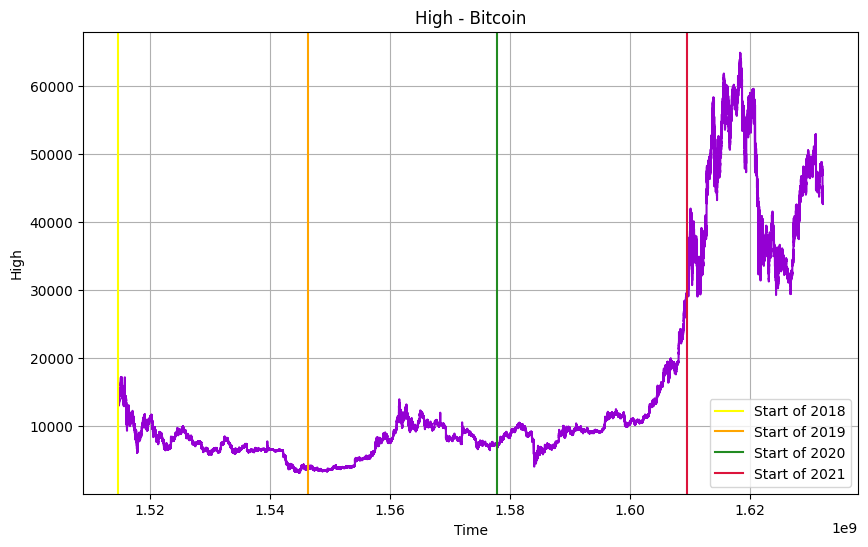

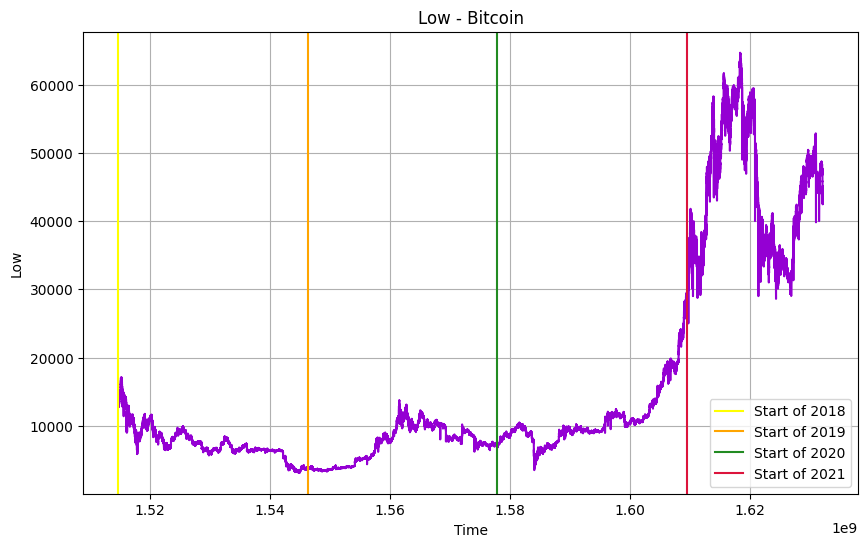

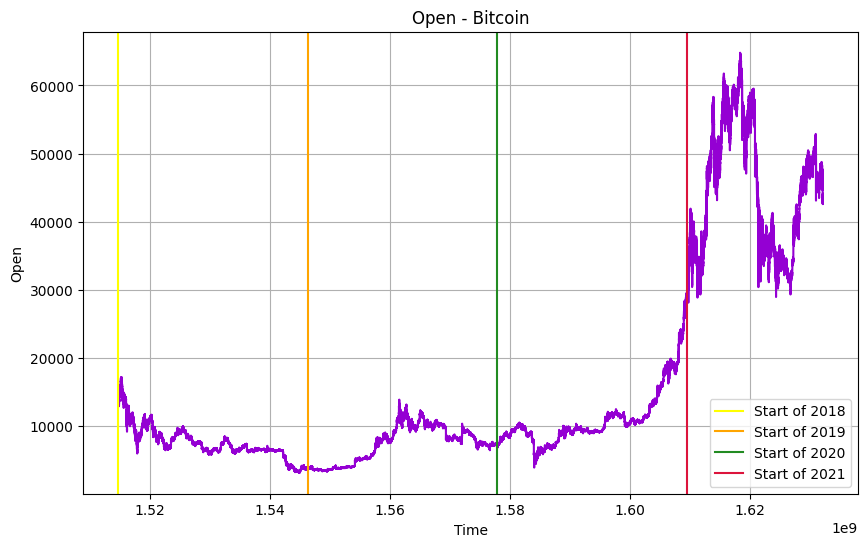

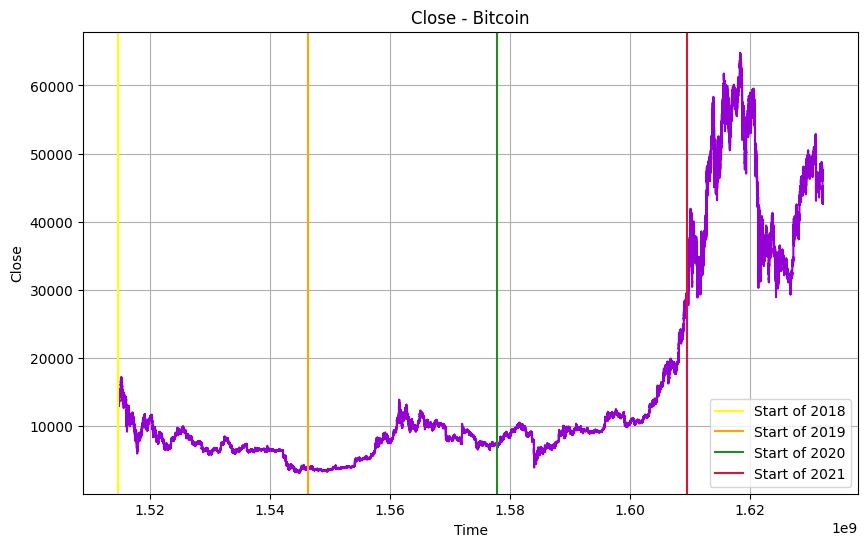

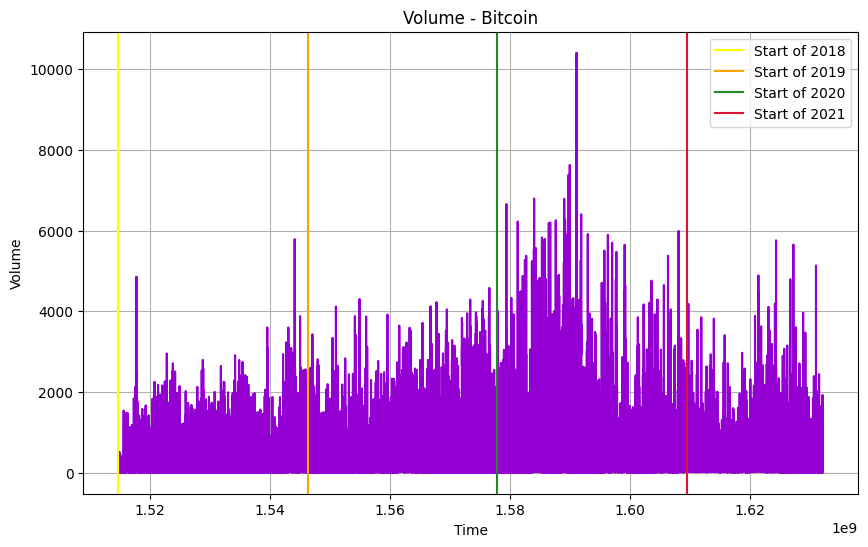

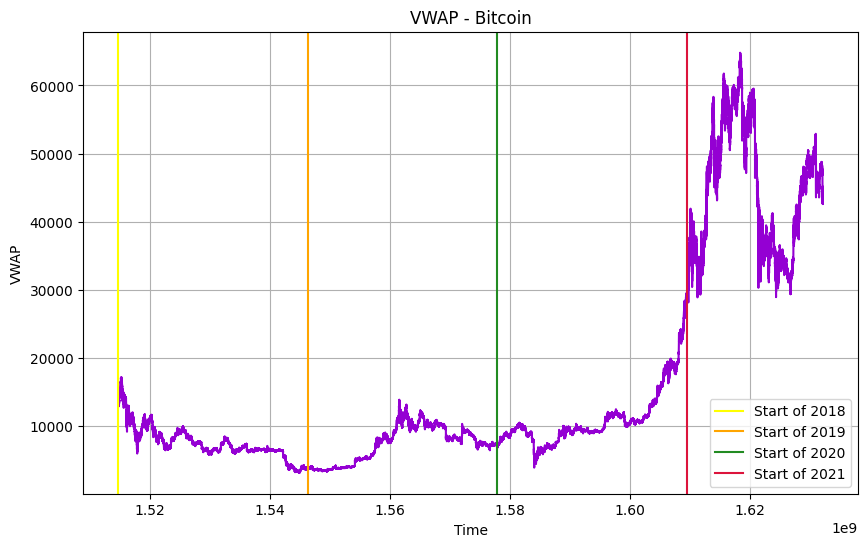

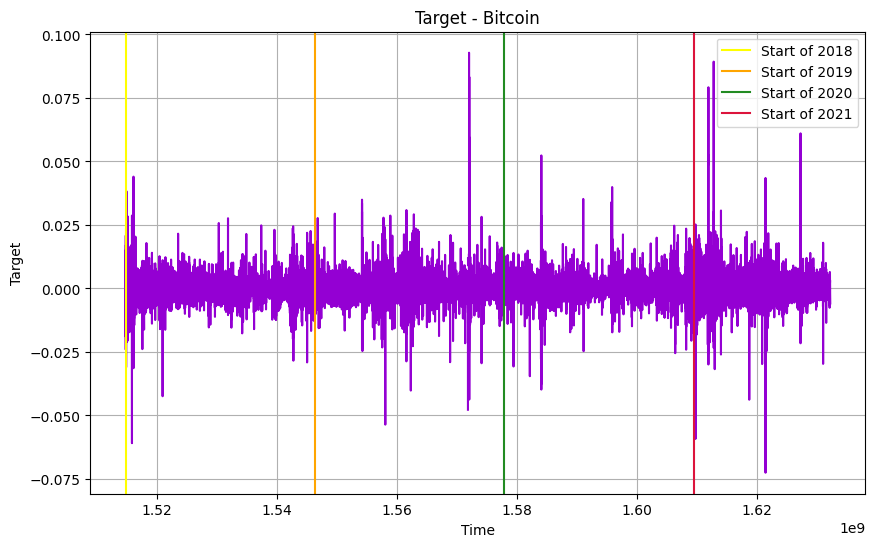

In [7]:
#EDA
##Plotting features for Bitcoin over time

cols = ['High', 'Low', 'Open', 'Close', 'Volume', 'VWAP', 'Target']

for x in cols:
    f = plt.figure(figsize = (10,6))

    ax = f.add_subplot(111)
    ax.set_facecolor('white')
    plt.plot(train_data_bitcoin.set_index('timestamp')[x], c = 'darkviolet')
    plt.axvline(x = 1514764860, label = 'Start of 2018', c = 'yellow')
    plt.axvline(x = 1546300860, label = 'Start of 2019', c = 'orange')
    plt.axvline(x = 1577836860, label = 'Start of 2020', c = 'forestgreen')
    plt.axvline(x = 1609459260, label = 'Start of 2021', c = 'crimson')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel(x)
    plt.grid()
    plt.title(x + ' - Bitcoin')

    plt.show()

In [8]:
#Limit training data to 2021 for Bitcoin based on above information
train_data_bitcoin = train_data_bitcoin.loc['2021-01-01 00:01:00':'2021-09-21 00:00:00']
train_data_bitcoin.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
date,,,,,,,,,,
2021-01-01 00:01:00,1609459260,1,4039.0,28985.511250,29086.90,28960.0,29032.387500,163.787036,29017.664870,0.000396
2021-01-01 00:02:00,1609459320,1,1969.0,29031.175000,29079.56,28951.5,29002.956734,98.754670,29014.703526,-0.000069
2021-01-01 00:03:00,1609459380,1,1689.0,29002.977509,29069.39,28967.8,29005.580000,55.202131,29003.078663,-0.000137
2021-01-01 00:04:00,1609459440,1,1146.0,29004.293750,29057.73,28971.8,29000.490000,56.575903,29006.256629,-0.000682
2021-01-01 00:05:00,1609459500,1,2088.0,28994.918934,29031.71,28929.3,28962.285818,70.319136,28972.005783,-0.000446


## Missing Value Treatment

In [9]:
train_data_bitcoin[train_data_bitcoin['Target'].isna()]

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
date,,,,,,,,,,
2021-02-08 10:57:00,1612781820,1,2112.0,39404.022857,39444.410000,39337.30,39390.941429,84.979569,39392.293531,NaN
2021-02-08 11:12:00,1612782720,1,1188.0,39410.160000,39450.300000,39374.26,39413.811667,38.199654,39410.659032,NaN
2021-09-20 23:45:00,1632181500,1,2177.0,42655.528484,42715.990000,42630.17,42678.721429,93.523647,42679.036829,NaN
2021-09-20 23:46:00,1632181560,1,2352.0,42688.935000,42810.260000,42662.27,42778.291250,97.442472,42739.891567,NaN
2021-09-20 23:47:00,1632181620,1,2080.0,42790.287143,42828.000000,42742.36,42790.175714,97.634234,42794.666167,NaN
2021-09-20 23:48:00,1632181680,1,2058.0,42792.855714,42827.700000,42713.48,42731.731429,78.468814,42786.068940,NaN
2021-09-20 23:49:00,1632181740,1,3717.0,42745.153750,42937.310000,42713.48,42898.565000,116.567006,42828.789861,NaN
2021-09-20 23:50:00,1632181800,1,3253.0,42896.174286,42966.980000,42852.07,42939.645714,113.220529,42910.257438,NaN
2021-09-20 23:51:00,1632181860,1,2264.0,42937.784286,42971.950000,42899.10,42927.167143,56.655507,42932.332787,NaN


In [10]:
# Calculate the rolling mean of the Target column
windows = 15
periods = 1

rolling_mean = train_data_bitcoin['Target'].rolling(window=windows, min_periods=periods).mean()

# Fill missing values in the Target column with the rolling mean
train_data_bitcoin['Target'] = train_data_bitcoin['Target'].fillna(rolling_mean)

# Fill missing values in the Target column using linear interpolation
train_data_bitcoin['Target'] = train_data_bitcoin['Target'].interpolate(method='linear')

In [11]:
# train_data_bitcoin['Target'] = train_data_bitcoin['Target'].interpolate(method='linear')

## Model

In [12]:
EPOCHS        = 1000
DROPOUT       = 0.2
DIRECTIONS    = 1
NUM_LAYERS    = 2
BATCH_SIZE    = 32
OUTPUT_SIZE   = 1
SEQ_LENGTH    = 15
NUM_FEATURES  = 6
UNITS   = [256, 128]
LEARNING_RATE = 0.0001
TARGET        = "Target"
FEATURES      = ['High', 'Low', 'VWAP', 'Volume', 'Target']

##### train_data_new['Target'] = train_data_new['Target'].fillna(train_data_new['Target'].rolling(15, min_periods=1).mean())

In [13]:
#Data Preprocessing
train_data_bitcoin = train_data_bitcoin.sort_values(by="timestamp", ascending=True)
X = train_data_bitcoin[FEATURES].values
y = train_data_bitcoin[TARGET].values

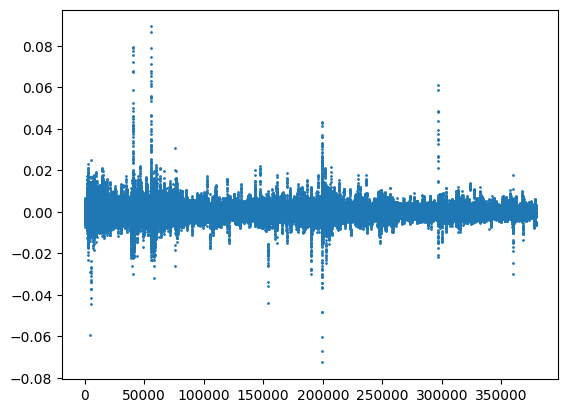

In [14]:
#Target variable
plt.scatter(range(len(y)), y, s=1)

{'whiskers': [<matplotlib.lines.Line2D at 0x7a4da0feba00>,
 'caps': [<matplotlib.lines.Line2D at 0x7a4da0febf40>,
 'boxes': [<matplotlib.lines.Line2D at 0x7a4da0feb730>],
 'medians': [<matplotlib.lines.Line2D at 0x7a4da10244c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7a4da1024760>],
 'means': []}

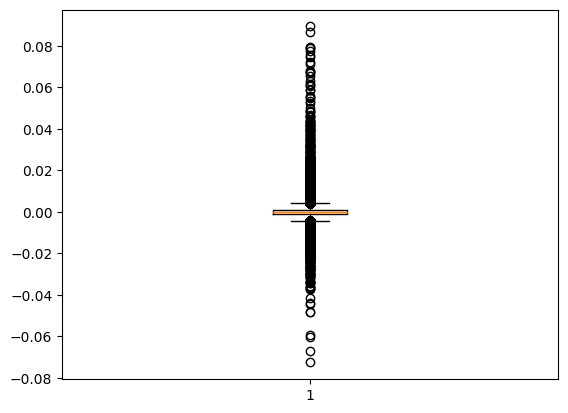

In [15]:
#Target variable
plt.boxplot(y)

(array([8.15805371e-04, 8.15805371e-04, 0.00000000e+00, 8.15805371e-04,
        8.15805371e-04, 0.00000000e+00, 0.00000000e+00, 1.63161074e-03,
        1.63161074e-03, 8.15805371e-04, 8.15805371e-04, 6.52644297e-03,
        5.71063760e-03, 1.06054698e-02, 1.06054698e-02, 3.18164095e-02,
        6.20012082e-02, 1.41950135e-01, 3.01847987e-01, 1.02628316e+00,
        5.88440414e+00, 5.76798871e+01, 2.03807761e+02, 3.29830111e+01,
        4.91767478e+00, 1.28897249e+00, 4.58482618e-01, 1.44397551e-01,
        6.85276511e-02, 2.52899665e-02, 1.55003020e-02, 9.78966445e-03,
        1.14212752e-02, 8.15805371e-03, 8.15805371e-03, 8.97385908e-03,
        4.07902685e-03, 3.26322148e-03, 1.63161074e-03, 2.44741611e-03,
        1.63161074e-03, 3.26322148e-03, 8.15805371e-04, 3.26322148e-03,
        1.63161074e-03, 1.63161074e-03, 3.26322148e-03, 0.00000000e+00,
        0.00000000e+00, 1.63161074e-03]),
 array([-0.07255649, -0.06931977, -0.06608305, -0.06284632, -0.0596096 ,
        -0.05637288, 

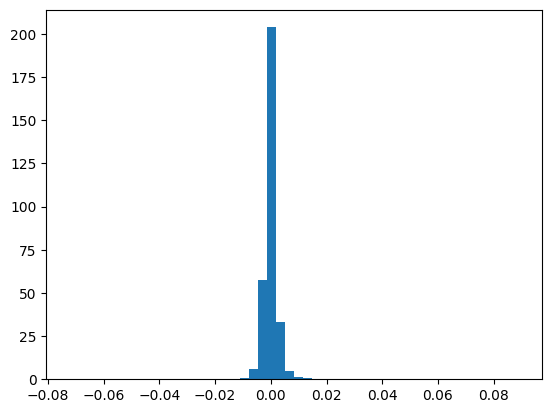

In [16]:
#Target variable
plt.hist(y, density=True, bins=50)

In [17]:
# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

In [18]:
# Normalize the Target
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y.reshape(-1,1))

In [19]:
#Check range for Target
y_scaled.min(), y_scaled.max()

(0.0, 1.0)

In [20]:
#Confirm Target Shape
print(y.shape)
print(y_scaled.shape)

(378711,)
(378711, 1)


In [21]:
# Function to prepare time series data for RNN
def prepare_data(data, target, time_steps, steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(target[i + time_steps: i + time_steps + steps])
    return np.array(X), np.array(y)

In [22]:
# Function to prepare time series data for RNN
def prepare_data2(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
    return np.array(X), np.array(y)

In [23]:
# Define the number of time steps for the LSTM
time_steps = SEQ_LENGTH
steps = 1

# Prepare time series data
X_rnn, y_rnn = prepare_data(X_scaled, y_scaled, time_steps, steps)

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_rnn, y_rnn, test_size=0.2, shuffle=False)

# Split the validation data into testing and validation sets
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, shuffle=False)

In [24]:
y_train

array([[[0.46099396]],

       [[0.46232143]],

       [[0.46229314]],

       ...,

       [[0.44534801]],

       [[0.45055273]],

       [[0.4495555 ]]])

In [25]:
y_test

array([[[0.45097429]],

       [[0.45221774]],

       [[0.45272615]],

       ...,

       [[0.46517674]],

       [[0.46517674]],

       [[0.46517674]]])

In [26]:
y_rnn

array([[[0.46099396]],

       [[0.46232143]],

       [[0.46229314]],

       ...,

       [[0.46517674]],

       [[0.46517674]],

       [[0.46517674]]])

In [27]:
#Check for NAs
print(np.isnan(X_train).any())
print(np.isnan(y_train).any())

False
False


In [28]:
# X_train[np.isnan(X_train)] = 0
# y_train[np.isnan(y_train)] = y_train[~(np.isnan(y_train))].mean()

In [29]:
# # Step 3: Train an LSTM Model
# model = tf.keras.Sequential([
# #     tf.keras.layers.Embedding(X_train.shape[1], X_train.shape[2]),
#     tf.keras.layers.LSTM(20, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), dropout=0.1, recurrent_dropout=0.1, return_sequences=True),
#     tf.keras.layers.LSTM(15, activation='relu', dropout=0.1, recurrent_dropout=0.1, return_sequences=False),
#     tf.keras.layers.Dense(10),
#     tf.keras.layers.Dense(1)
# ])

# optimizer = optimizers.legacy.Adam(learning_rate=0.001)
# model.compile(optimizer=optimizer, loss='mean_squared_error')

In [30]:
# # Step 3: Train an LSTM Model
# model = tf.keras.Sequential([
#     tf.keras.layers.LSTM(UNITS, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), dropout=0.1, return_sequences=True),
#     tf.keras.layers.LSTM(UNITS, activation='relu', dropout=0.1, return_sequences=False),
#     tf.keras.layers.Dense(1)
# ])

# optimizer = optimizers.legacy.Adam(learning_rate=0.001)
# model.compile(optimizer=optimizer, loss='mean_squared_error')

In [31]:
X_train.shape

(302956, 15, 5)

In [32]:
DROPOUT = 0.1
# Step 3: Train an LSTM Model
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(16, 3, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'),
    tf.keras.layers.Conv1D(24, 3, activation='relu'),
    tf.keras.layers.Dropout(DROPOUT),
    tf.keras.layers.LSTM(20, dropout=DROPOUT, return_sequences=True),
#     tf.keras.layers.LSTM(15, dropout=DROPOUT, return_sequences=True),
    tf.keras.layers.LSTM(10, dropout=DROPOUT, return_sequences=False),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, clipvalue=0.5, weight_decay=0.001)
model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError())

In [33]:
# DROPOUT = 0.1
# # Step 3: Train an LSTM Model
# model = tf.keras.Sequential([
#     tf.keras.layers.LSTM(20, input_shape=(X_train.shape[1], X_train.shape[2]), dropout=DROPOUT, return_sequences=True),
#     tf.keras.layers.LSTM(15, dropout=DROPOUT, return_sequences=True),
#     tf.keras.layers.LSTM(10, dropout=DROPOUT, return_sequences=False),
#     tf.keras.layers.Dense(1)
# ])

# optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, clipvalue=0.5, weight_decay=0.001)
# model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError())

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 13, 16)            256       
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 24)            1176      
                                                                 
 dropout (Dropout)           (None, 11, 24)            0         
                                                                 
 lstm (LSTM)                 (None, 11, 20)            3600      
                                                                 
 lstm_1 (LSTM)               (None, 10)                1240      
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 6283 (24.54 KB)
Trainable params: 6283 (24

In [35]:
# history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_valid, y_valid), verbose=1)

EPOCHS = 100
BATCH = 256

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(X_train, y_train,
          batch_size=BATCH,
          epochs=EPOCHS,
          validation_data=(X_valid, y_valid),
          verbose = 1,
          callbacks = [early_stop])

Epoch 1/100


I0000 00:00:1708400471.872878      85 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1184/1184 [==============================] - 18s 8ms/step - loss: 0.0085 - val_loss: 7.0567e-05
Epoch 2/100
1184/1184 [==============================] - 8s 7ms/step - loss: 5.5021e-04 - val_loss: 7.0993e-05
Epoch 3/100
1184/1184 [==============================] - 8s 7ms/step - loss: 3.7105e-04 - val_loss: 7.6303e-05
Epoch 4/100
1184/1184 [==============================] - 8s 7ms/step - loss: 3.0099e-04 - val_loss: 7.9874e-05
Epoch 5/100
1184/1184 [==============================] - 9s 7ms/step - loss: 2.7677e-04 - val_loss: 7.8190e-05
Epoch 6/100
1184/1184 [==============================] - 8s 7ms/step - loss: 2.6340e-04 - val_loss: 7.8648e-05


## Predictions

In [36]:
#Save Model
model.save("best_model_bunny_btc.keras")

In [37]:
#Weights computed by model
model.get_weights()[0]

array([[[ 8.35395008e-02,  1.48088738e-01,  2.34080747e-01,
          1.02759033e-01, -1.36928499e-01,  6.30263463e-02,
         -1.23282909e-01,  1.68676928e-01,  1.37164772e-01,
         -2.36989647e-01,  1.26635984e-01, -1.28467707e-02,
          1.38170898e-01,  1.50849611e-01,  7.59944916e-02,
         -1.11585423e-01],
        [-2.66465157e-01, -5.37862442e-02,  1.66769564e-01,
         -1.83490857e-01, -2.51254976e-01,  5.99231012e-02,
         -2.81492591e-01, -2.18056902e-01,  1.71368748e-01,
         -8.28699842e-02, -2.13350683e-01,  9.12226066e-02,
         -2.04562217e-01,  2.48249695e-01,  4.17113453e-02,
         -2.68863440e-01],
        [ 2.66716093e-01, -9.75828841e-02,  9.97934416e-02,
          1.73214138e-01, -1.22662567e-01,  9.15737376e-02,
          2.24832073e-01,  8.18203855e-03, -7.19425455e-02,
          7.43593425e-02, -2.58590169e-02,  2.22634733e-01,
          8.24796557e-02,  3.16662252e-01, -1.83361411e-01,
         -5.47735095e-02],
        [-3.0767658

In [38]:
#Make Predictions
train_predictions = model.predict(X_train)
valid_predictions = model.predict(X_valid)
test_predictions = model.predict(X_test)

1184/1184 [==============================] - 3s 3ms/step


In [39]:
#Check shape
print(y_train.shape)
print(train_predictions.shape)

(302956, 1, 1)
(302956, 1)


In [40]:
#Check for NAs in predictions
np.isnan(valid_predictions).any()
np.isnan(test_predictions).any()

False

## Results

In [41]:
#Evaluate the Model
train_rmse = np.sqrt(mean_squared_error(y_train.flatten(), train_predictions))
valid_rmse = np.sqrt(mean_squared_error(y_valid.flatten(), valid_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test.flatten(), test_predictions))

print("Train RMSE:", train_rmse)
print("Validation RMSE:", valid_rmse)
print("Test RMSE:", test_rmse)

Train RMSE: 0.01474317017060469
Validation RMSE: 0.008400399368128836
Test RMSE: 0.007371355002436891


In [42]:
asset_details = asset_details[asset_details["Asset_ID"]==1]
print(asset_details)

   Asset_ID    Weight Asset_Name
2         1  6.779922    Bitcoin


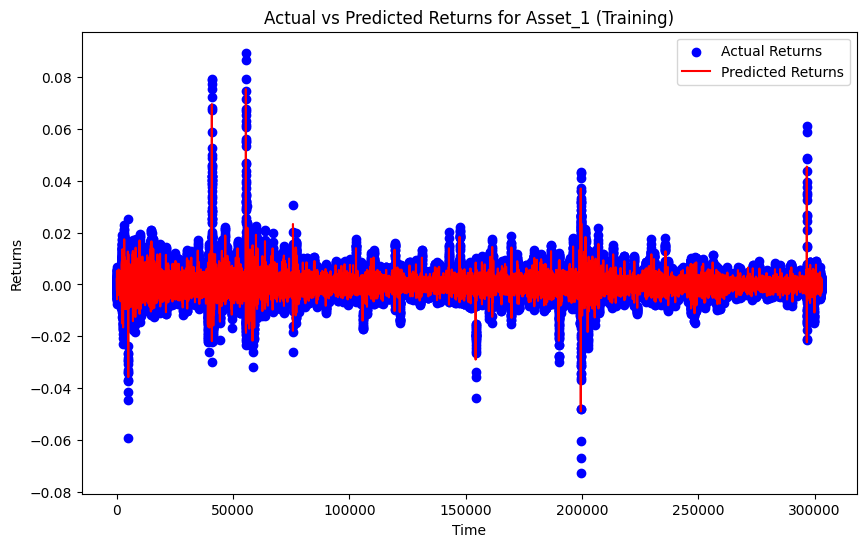

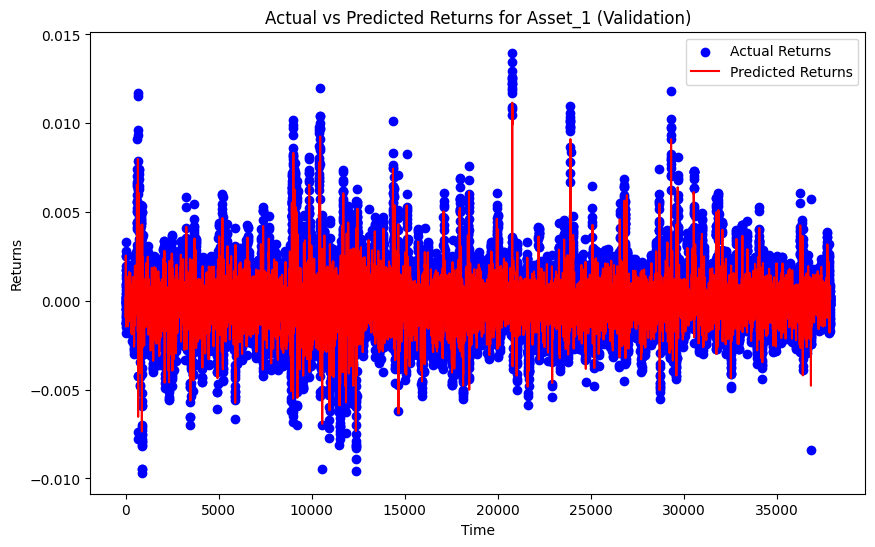

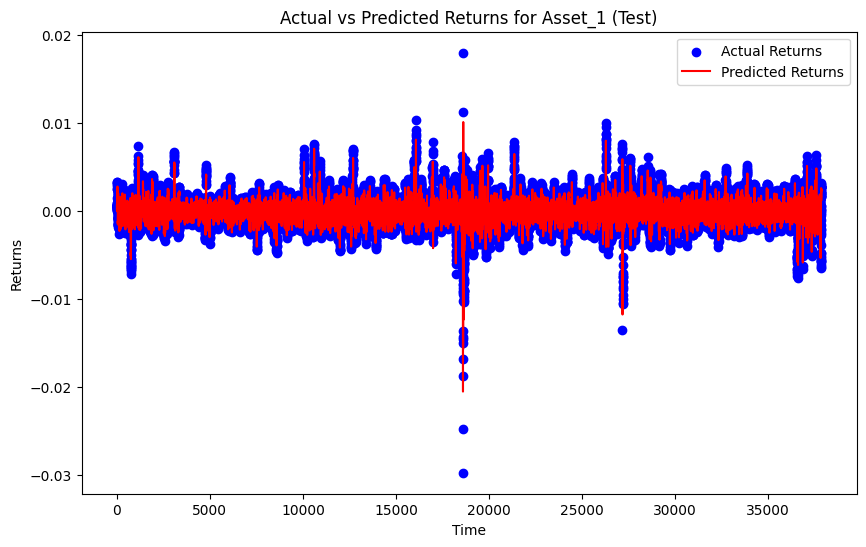

In [43]:
# Plot actual vs predicted returns
def plot_actual_vs_predicted(actual, predicted, asset_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(actual)), actual, label='Actual Returns', color='blue')
    plt.plot(predicted, label='Predicted Returns', color='red')
    plt.title(f'Actual vs Predicted Returns for {asset_name}')
    plt.xlabel('Time')
    plt.ylabel('Returns')
    plt.legend()
    plt.show()

asset_name = f'Asset_{1}' 
actual_train_returns = scaler_y.inverse_transform(y_train.reshape(-1,1))
predicted_train_returns =  scaler_y.inverse_transform(train_predictions)
actual_valid_returns =  scaler_y.inverse_transform(y_valid.reshape(-1,1))
predicted_valid_returns =  scaler_y.inverse_transform(valid_predictions)
actual_test_returns = scaler_y.inverse_transform(y_test.reshape(-1,1))
predicted_test_returns =  scaler_y.inverse_transform(test_predictions)
plot_actual_vs_predicted(actual_train_returns, predicted_train_returns, asset_name + ' (Training)')
plot_actual_vs_predicted(actual_valid_returns, predicted_valid_returns, asset_name + ' (Validation)')
plot_actual_vs_predicted(actual_test_returns, predicted_test_returns, asset_name + ' (Test)')


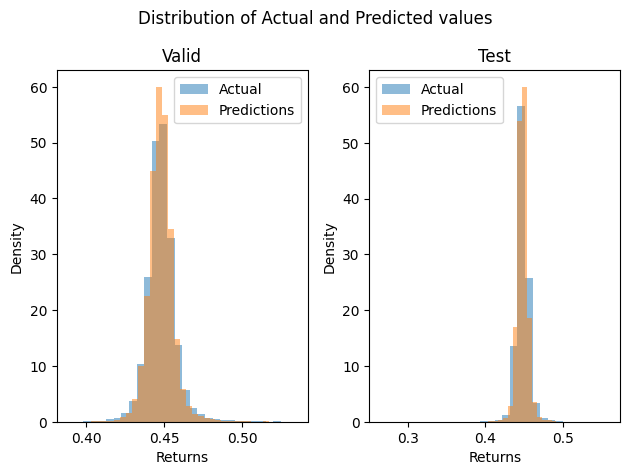

In [44]:
#Distribution of True and Predictions for Valid
plt.subplot(1, 2, 1)
plt.hist(y_valid.flatten(), density=True, bins=30, alpha = 0.5, label="Actual")
plt.hist(valid_predictions, density=True, bins=30, alpha = 0.5, label="Predictions")
plt.title('Valid')
plt.xlabel('Returns')
plt.ylabel('Density')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(y_test.flatten(), density=True, bins=30, alpha = 0.5, label="Actual")
plt.hist(test_predictions, density=True, bins=30, alpha = 0.5, label="Predictions")
plt.title('Test')
plt.xlabel('Returns')
plt.ylabel('Density')
plt.legend()

plt.suptitle("Distribution of Actual and Predicted values")

plt.tight_layout()
plt.show()

In [45]:
# To calculate Pearson's correlation coefficient
# x=np.corrcoef(actual_valid_returns,predicted_valid_returns)

# Printing the correlation coefficients:
# print(x)

# Ethereum

## EDA

In [46]:
#Subet train_df for Ethereum data and sort by timestamp
train_data_ethereum = train_data[train_data["Asset_ID"].isin([6])]
train_data_ethereum = train_data_ethereum.sort_values(by=['timestamp'])
train_data_ethereum.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
5,1514764860,6,173.0,738.3025,746.00,732.51,738.5075,335.987856,738.839291,-0.004809
13,1514764920,6,192.0,738.5075,745.14,732.49,738.2600,232.793141,738.268967,-0.004441
21,1514764980,6,120.0,738.3325,745.12,730.00,737.5025,174.138031,737.994457,-0.004206
29,1514765040,6,156.0,737.2225,744.69,728.93,737.1025,165.383926,737.303631,-0.002205
37,1514765100,6,118.0,736.5300,743.80,727.11,735.7050,193.078039,736.163026,-0.001744


In [47]:
#Convert timestamp to datetime format and set as index
train_data_ethereum['date'] = pd.to_datetime(train_data_ethereum['timestamp'], unit='s')
train_data_ethereum = train_data_ethereum.set_index('date')
train_data_ethereum.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
date,,,,,,,,,,
2018-01-01 00:01:00,1514764860,6,173.0,738.3025,746.00,732.51,738.5075,335.987856,738.839291,-0.004809
2018-01-01 00:02:00,1514764920,6,192.0,738.5075,745.14,732.49,738.2600,232.793141,738.268967,-0.004441
2018-01-01 00:03:00,1514764980,6,120.0,738.3325,745.12,730.00,737.5025,174.138031,737.994457,-0.004206
2018-01-01 00:04:00,1514765040,6,156.0,737.2225,744.69,728.93,737.1025,165.383926,737.303631,-0.002205
2018-01-01 00:05:00,1514765100,6,118.0,736.5300,743.80,727.11,735.7050,193.078039,736.163026,-0.001744


In [48]:
#EDA - Time range
train_data_ethereum.index.min(), train_data_ethereum.index.max()

(Timestamp('2018-01-01 00:01:00'), Timestamp('2021-09-21 00:00:00'))

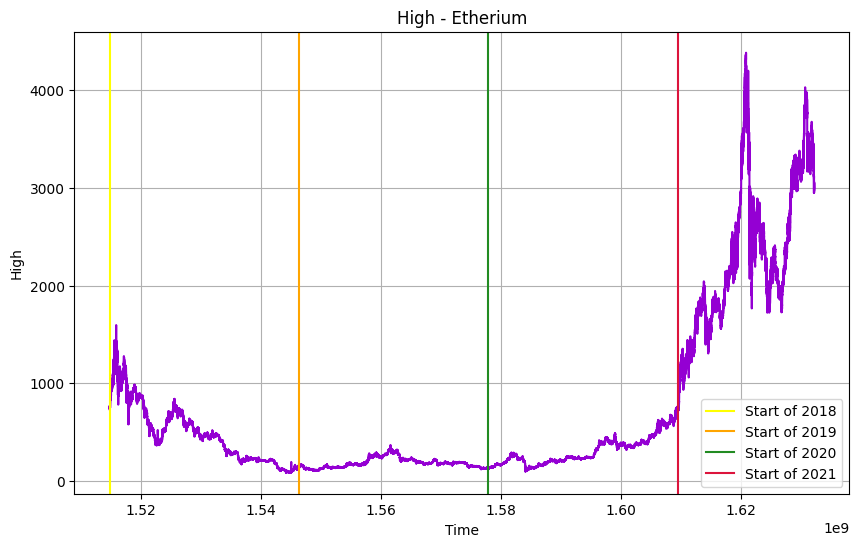

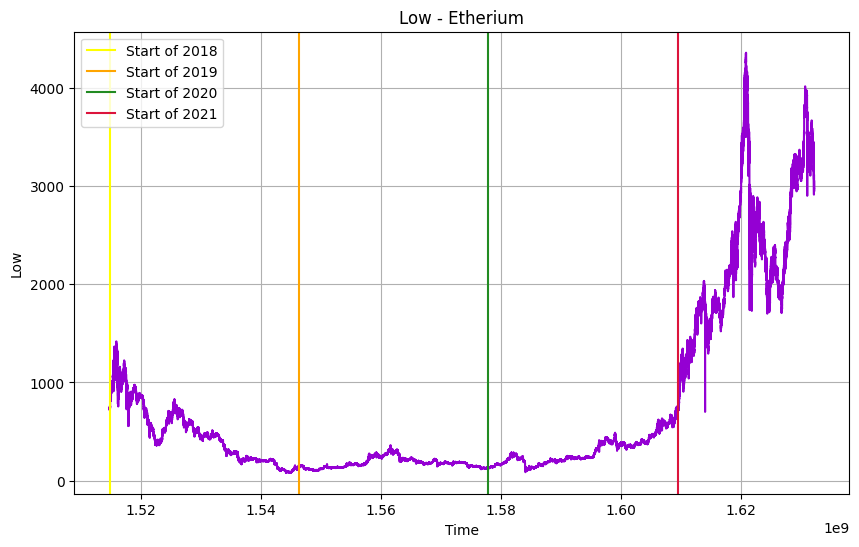

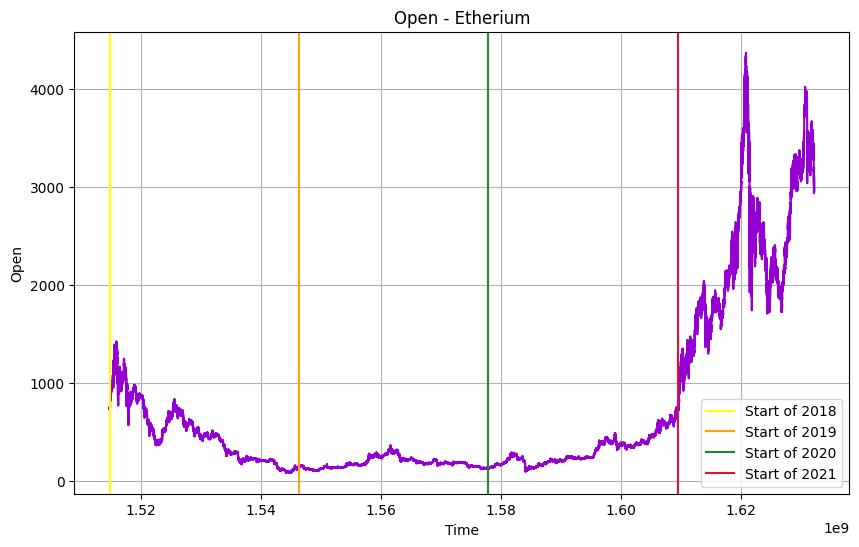

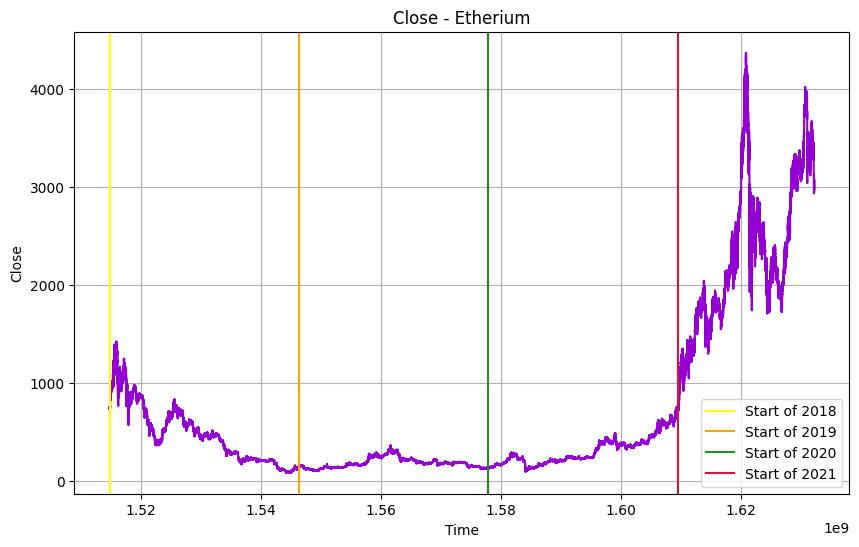

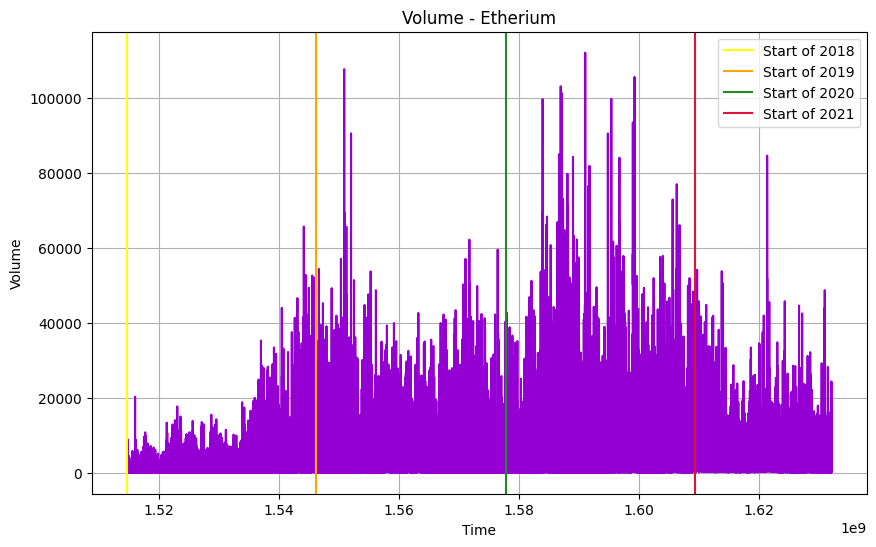

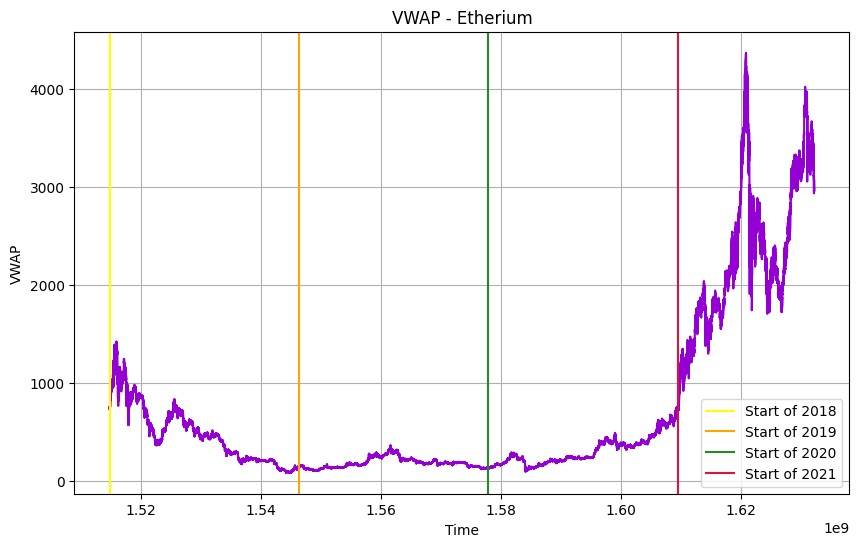

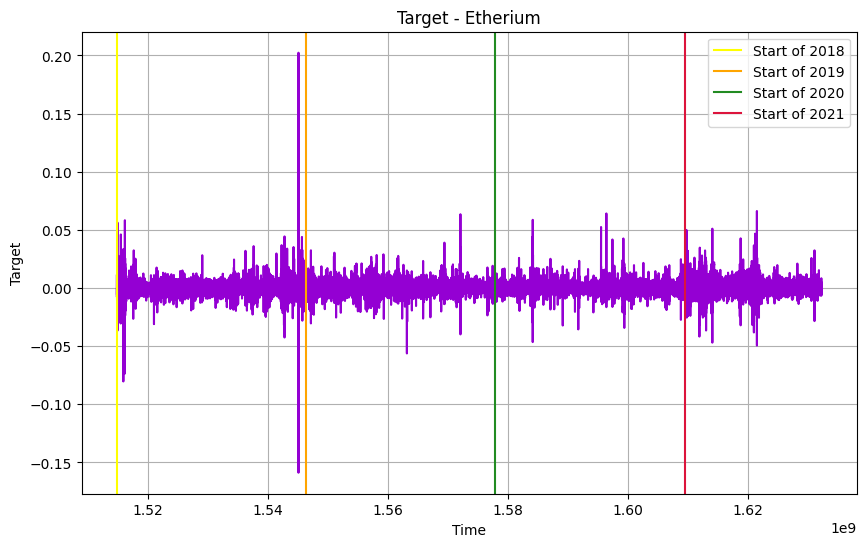

In [108]:
#EDA
##Plotting features for Ethereum over time

cols = ['High', 'Low', 'Open', 'Close', 'Volume', 'VWAP', 'Target']

for x in cols:
    f = plt.figure(figsize = (10,6))

    ax = f.add_subplot(111)
    ax.set_facecolor('white')
    plt.plot(train_data_ethereum.set_index('timestamp')[x], c = 'darkviolet')
    plt.axvline(x = 1514764860, label = 'Start of 2018', c = 'yellow')
    plt.axvline(x = 1546300860, label = 'Start of 2019', c = 'orange')
    plt.axvline(x = 1577836860, label = 'Start of 2020', c = 'forestgreen')
    plt.axvline(x = 1609459260, label = 'Start of 2021', c = 'crimson')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel(x)
    plt.grid()
    plt.title(x + ' - Ethereum')

    plt.show()

In [109]:
#Limit training data to 2021 for Bitcoin based on above information
train_data_ethereum = train_data_ethereum.loc['2021-01-01 00:01:00':'2021-09-21 00:00:00']
train_data_ethereum.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
date,,,,,,,,,,
2021-01-01 00:01:00,1609459260,6,1538.0,737.602857,740.69,736.760000,739.341429,2031.161912,738.614225,-0.001312
2021-01-01 00:02:00,1609459320,6,643.0,739.121429,740.33,737.156623,738.344286,690.288835,738.621065,-0.001679
2021-01-01 00:03:00,1609459380,6,538.0,738.130694,739.90,737.280000,737.970515,778.729412,738.322659,-0.001537
2021-01-01 00:04:00,1609459440,6,610.0,737.892857,739.28,736.290000,737.477143,703.652419,737.768842,-0.001755
2021-01-01 00:05:00,1609459500,6,1115.0,737.528936,738.53,735.300000,736.182857,1135.049781,736.564849,-0.001540


In [56]:
train_data_ethereum.shape

(1956200, 10)

## Missing Value Treatment

In [110]:
train_data_ethereum[train_data_ethereum['Target'].isna()]

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
date,,,,,,,,,,
2021-02-08 11:04:00,1612782240,6,3327.0,1655.115714,1658.26,1651.23,1656.261429,2672.744175,1654.565771,NaN
2021-02-08 11:19:00,1612783140,6,1550.0,1656.622857,1658.92,1652.80,1655.407143,1156.394811,1655.822616,NaN
2021-05-13 16:51:00,1620924660,6,12742.0,3736.685714,3746.65,3698.72,3710.061429,8290.795799,3717.448033,NaN
2021-05-13 16:52:00,1620924720,6,10790.0,3710.378571,3722.90,3696.90,3706.872857,7512.836055,3708.332551,NaN
2021-05-13 16:53:00,1620924780,6,6739.0,3706.338571,3723.73,3702.39,3710.018571,4466.893479,3714.668888,NaN
2021-05-13 17:06:00,1620925560,6,305.0,3667.750000,3685.00,3666.36,3673.307500,203.379383,3670.120348,NaN
2021-09-20 23:45:00,1632181500,6,2136.0,2955.425714,2960.23,2952.00,2953.845739,1039.819802,2954.909916,NaN
2021-09-20 23:46:00,1632181560,6,2232.0,2954.987143,2965.91,2952.71,2962.108571,988.495383,2959.758004,NaN
2021-09-20 23:47:00,1632181620,6,1818.0,2963.701429,2966.19,2962.21,2963.394286,543.637417,2964.446210,NaN


In [111]:
# Calculate the rolling mean of the Target column
windows = 15
periods = 1

rolling_mean = train_data_ethereum['Target'].rolling(window=windows, min_periods=periods).mean()

# Fill missing values in the Target column with the rolling mean
train_data_ethereum['Target'] = train_data_ethereum['Target'].fillna(rolling_mean)

# Fill missing values in the Target column using linear interpolation
train_data_ethereum['Target'] = train_data_ethereum['Target'].interpolate(method='linear')

## Model

In [112]:
EPOCHS        = 1000
DROPOUT       = 0.2
DIRECTIONS    = 1
NUM_LAYERS    = 2
BATCH_SIZE    = 32
OUTPUT_SIZE   = 1
SEQ_LENGTH    = 15
NUM_FEATURES  = 6
UNITS   = [256, 128]
LEARNING_RATE = 0.0001
TARGET        = "Target"
FEATURES      = ['High', 'Low', 'VWAP', 'Volume', 'Target']

##### train_data_new['Target'] = train_data_new['Target'].fillna(train_data_new['Target'].rolling(15, min_periods=1).mean())

In [113]:
#Data Preprocessing
train_data_ethereum = train_data_ethereum.sort_values(by="timestamp", ascending=True)
X = train_data_ethereum[FEATURES].values
y = train_data_ethereum[TARGET].values

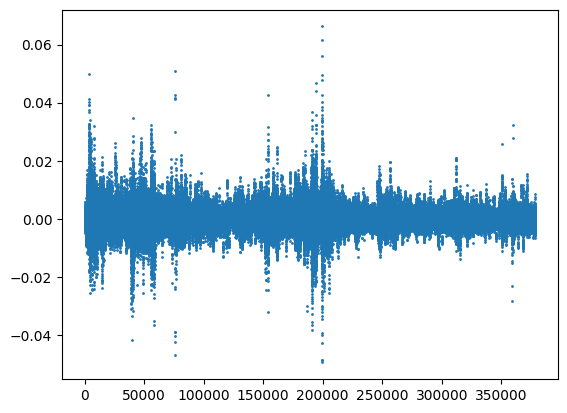

In [114]:
#Target variable
plt.scatter(range(len(y)), y, s=1)

{'whiskers': [<matplotlib.lines.Line2D at 0x7d0a51fd9fc0>,
 'caps': [<matplotlib.lines.Line2D at 0x7d0a51e310f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7d0a51efdb70>],
 'medians': [<matplotlib.lines.Line2D at 0x7d0a51e31630>],
 'fliers': [<matplotlib.lines.Line2D at 0x7d0a51e318d0>],
 'means': []}

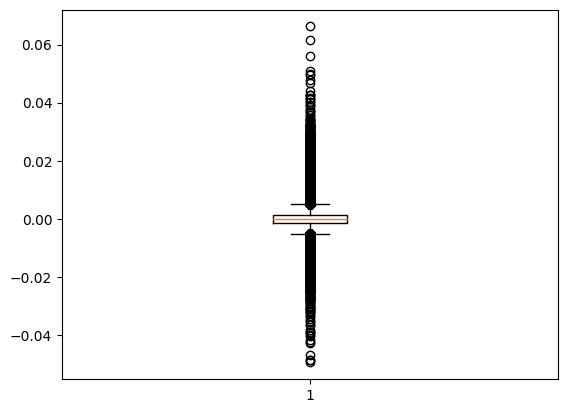

In [115]:
#Target variable
plt.boxplot(y)

(array([3.42202494e-03, 1.14067498e-03, 1.14067498e-03, 3.42202494e-03,
        5.70337490e-03, 2.28134996e-03, 5.70337490e-03, 5.70337490e-03,
        1.14067498e-02, 1.71101247e-02, 2.96575495e-02, 5.70337490e-02,
        8.21285986e-02, 1.20911548e-01, 2.33838371e-01, 3.96954893e-01,
        9.14821334e-01, 2.33153966e+00, 6.65355716e+00, 2.37066481e+01,
        1.04801795e+02, 1.97818136e+02, 6.69986856e+01, 1.71705805e+01,
        5.84824062e+00, 2.37374463e+00, 1.08592258e+00, 5.45242640e-01,
        2.88590770e-01, 1.46006397e-01, 8.89726484e-02, 7.30031987e-02,
        4.90490241e-02, 3.42202494e-02, 2.16728246e-02, 1.93914747e-02,
        7.98472486e-03, 4.56269992e-03, 5.70337490e-03, 6.84404988e-03,
        1.14067498e-03, 2.28134996e-03, 2.28134996e-03, 1.14067498e-03,
        0.00000000e+00, 1.14067498e-03, 0.00000000e+00, 0.00000000e+00,
        1.14067498e-03, 1.14067498e-03]),
 array([-0.04949772, -0.04718281, -0.0448679 , -0.042553  , -0.04023809,
        -0.03792318, 

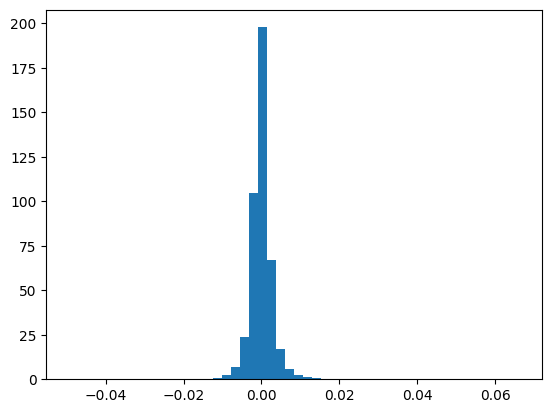

In [116]:
#Target variable
plt.hist(y, density=True, bins=50)

In [117]:
# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

In [118]:
# Normalize the Target
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y.reshape(-1,1))

In [119]:
#Check range for Target
y_scaled.min(), y_scaled.max()

(0.0, 1.0)

In [120]:
#Confirm Target Shape
print(y.shape)
print(y_scaled.shape)

(378708,)
(378708, 1)


In [121]:
# Function to prepare time series data for RNN
def prepare_data(data, target, time_steps, steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(target[i + time_steps: i + time_steps + steps])
    return np.array(X), np.array(y)

In [122]:
# Function to prepare time series data for RNN
def prepare_data2(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
    return np.array(X), np.array(y)

In [123]:
# Define the number of time steps for the LSTM
time_steps = SEQ_LENGTH
steps = 1

# Prepare time series data
X_rnn, y_rnn = prepare_data(X_scaled, y_scaled, time_steps, steps)

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_rnn, y_rnn, test_size=0.2, shuffle=False)

# Split the validation data into testing and validation sets
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, shuffle=False)

In [124]:
y_train

array([[[0.42858614]],

       [[0.43324044]],

       [[0.43768456]],

       ...,

       [[0.44161706]],

       [[0.45327073]],

       [[0.45270189]]])

In [125]:
y_test

array([[[0.44030529]],

       [[0.44011268]],

       [[0.44046173]],

       ...,

       [[0.42465473]],

       [[0.42465473]],

       [[0.42465473]]])

In [126]:
y_rnn

array([[[0.42858614]],

       [[0.43324044]],

       [[0.43768456]],

       ...,

       [[0.42465473]],

       [[0.42465473]],

       [[0.42465473]]])

In [127]:
#Check for NAs
print(np.isnan(X_train).any())
print(np.isnan(y_train).any())

False
False


In [128]:
# X_train[np.isnan(X_train)] = 0
# y_train[np.isnan(y_train)] = y_train[~(np.isnan(y_train))].mean()

In [129]:
# # Step 3: Train an LSTM Model
# model = tf.keras.Sequential([
# #     tf.keras.layers.Embedding(X_train.shape[1], X_train.shape[2]),
#     tf.keras.layers.LSTM(20, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), dropout=0.1, recurrent_dropout=0.1, return_sequences=True),
#     tf.keras.layers.LSTM(15, activation='relu', dropout=0.1, recurrent_dropout=0.1, return_sequences=False),
#     tf.keras.layers.Dense(10),
#     tf.keras.layers.Dense(1)
# ])

# optimizer = optimizers.legacy.Adam(learning_rate=0.001)
# model.compile(optimizer=optimizer, loss='mean_squared_error')

In [130]:
# # Step 3: Train an LSTM Model
# model = tf.keras.Sequential([
#     tf.keras.layers.LSTM(UNITS, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), dropout=0.1, return_sequences=True),
#     tf.keras.layers.LSTM(UNITS, activation='relu', dropout=0.1, return_sequences=False),
#     tf.keras.layers.Dense(1)
# ])

# optimizer = optimizers.legacy.Adam(learning_rate=0.001)
# model.compile(optimizer=optimizer, loss='mean_squared_error')

In [131]:
X_train.shape

(302954, 15, 5)

In [132]:
DROPOUT = 0.1
# Step 3: Train an LSTM Model
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(16, 3, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'),
    tf.keras.layers.Conv1D(24, 3, activation='relu'),
    tf.keras.layers.Dropout(DROPOUT),
    tf.keras.layers.LSTM(20, dropout=DROPOUT, return_sequences=True),
#     tf.keras.layers.LSTM(15, dropout=DROPOUT, return_sequences=True),
    tf.keras.layers.LSTM(10, dropout=DROPOUT, return_sequences=False),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, clipvalue=0.5, weight_decay=0.001)
model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError())

In [133]:
# DROPOUT = 0.1
# # Step 3: Train an LSTM Model
# model = tf.keras.Sequential([
#     tf.keras.layers.LSTM(20, input_shape=(X_train.shape[1], X_train.shape[2]), dropout=DROPOUT, return_sequences=True),
#     tf.keras.layers.LSTM(15, dropout=DROPOUT, return_sequences=True),
#     tf.keras.layers.LSTM(10, dropout=DROPOUT, return_sequences=False),
#     tf.keras.layers.Dense(1)
# ])

# optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, clipvalue=0.5, weight_decay=0.001)
# model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError())

In [134]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 13, 16)            256       
                                                                 
 conv1d_7 (Conv1D)           (None, 11, 24)            1176      
                                                                 
 dropout_3 (Dropout)         (None, 11, 24)            0         
                                                                 
 lstm_6 (LSTM)               (None, 11, 20)            3600      
                                                                 
 lstm_7 (LSTM)               (None, 10)                1240      
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 6283 (24.54 KB)
Trainable params: 6283 (

In [135]:
# history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_valid, y_valid), verbose=1)

EPOCHS = 100
BATCH = 256

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(X_train, y_train,
          batch_size=BATCH,
          epochs=EPOCHS,
          validation_data=(X_valid, y_valid),
          verbose = 1,
          callbacks = [early_stop])

Epoch 1/100
1184/1184 [==============================] - 13s 8ms/step - loss: 0.0131 - val_loss: 2.0970e-04
Epoch 2/100
1184/1184 [==============================] - 8s 7ms/step - loss: 7.6921e-04 - val_loss: 2.1643e-04
Epoch 3/100
1184/1184 [==============================] - 8s 7ms/step - loss: 7.1260e-04 - val_loss: 2.0977e-04
Epoch 4/100
1184/1184 [==============================] - 9s 7ms/step - loss: 6.7997e-04 - val_loss: 1.9822e-04
Epoch 5/100
1184/1184 [==============================] - 9s 7ms/step - loss: 6.4108e-04 - val_loss: 1.7992e-04
Epoch 6/100
1184/1184 [==============================] - 9s 7ms/step - loss: 5.8014e-04 - val_loss: 1.4741e-04
Epoch 7/100
1184/1184 [==============================] - 9s 7ms/step - loss: 4.9146e-04 - val_loss: 1.1424e-04
Epoch 8/100
1184/1184 [==============================] - 9s 7ms/step - loss: 3.9155e-04 - val_loss: 9.7976e-05
Epoch 9/100
1184/1184 [==============================] - 9s 7ms/step - loss: 3.2621e-04 - val_loss: 7.8869e-05
Epoc

## Predictions

In [136]:
#Save Model
model.save("best_model_bunny_eth.keras")

In [137]:
#Weights computed by model
model.get_weights()[0]

array([[[ 0.04625694, -0.1420365 ,  0.04381543, -0.0381053 ,
          0.20668082,  0.18591239, -0.28483742, -0.03438633,
          0.06976935, -0.02508992, -0.24349995,  0.14444084,
         -0.21993724,  0.21680954,  0.24545482,  0.1785235 ],
        [ 0.03686947,  0.2601752 ,  0.12328633,  0.24466133,
         -0.02806858, -0.1516658 ,  0.05397698,  0.21902601,
          0.03051714,  0.2169346 , -0.07023951,  0.2665289 ,
         -0.22945286,  0.12979947, -0.03996098,  0.28891268],
        [-0.12433404, -0.10339237, -0.05967642,  0.03526082,
          0.16478106,  0.00087933, -0.13975792,  0.2572613 ,
         -0.08119085,  0.21213922, -0.1447456 , -0.05198097,
         -0.06476089,  0.21313031,  0.02158853,  0.3035821 ],
        [ 0.04416269, -0.21520145,  0.00857822,  0.17421976,
          0.0637054 , -0.11629543,  0.07503113, -0.05454506,
          0.1228812 ,  0.19655742, -0.01288261,  0.11417246,
         -0.12619637, -0.14168772, -0.28168115, -0.04573694],
        [ 0.06812716

In [138]:
#Make Predictions
train_predictions = model.predict(X_train)
valid_predictions = model.predict(X_valid)
test_predictions = model.predict(X_test)

1184/1184 [==============================] - 3s 3ms/step


In [139]:
#Check shape
print(y_train.shape)
print(train_predictions.shape)

(302954, 1, 1)
(302954, 1)


In [140]:
#Check for NAs in predictions
np.isnan(valid_predictions).any()
np.isnan(test_predictions).any()

False

## Results

In [141]:
#Evaluate the Model
train_rmse = np.sqrt(mean_squared_error(y_train.flatten(), train_predictions))
valid_rmse = np.sqrt(mean_squared_error(y_valid.flatten(), valid_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test.flatten(), test_predictions))

print("Train RMSE:", train_rmse)
print("Validation RMSE:", valid_rmse)
print("Test RMSE:", test_rmse)

Train RMSE: 0.010978919596981994
Validation RMSE: 0.0064043954171671
Test RMSE: 0.006394399826021493


In [144]:
asset_details = asset_details[asset_details["Asset_ID"]==6]
print(asset_details)

Empty DataFrame
Columns: [Asset_ID, Weight, Asset_Name]
Index: []


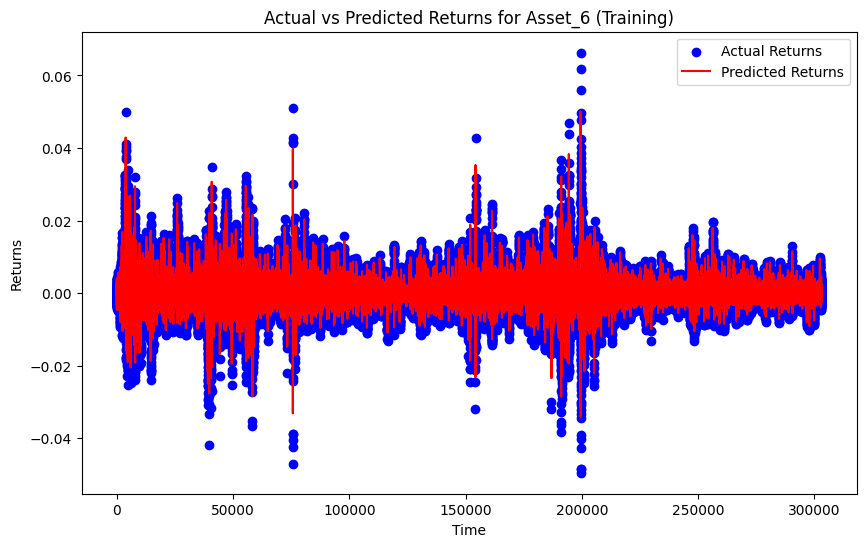

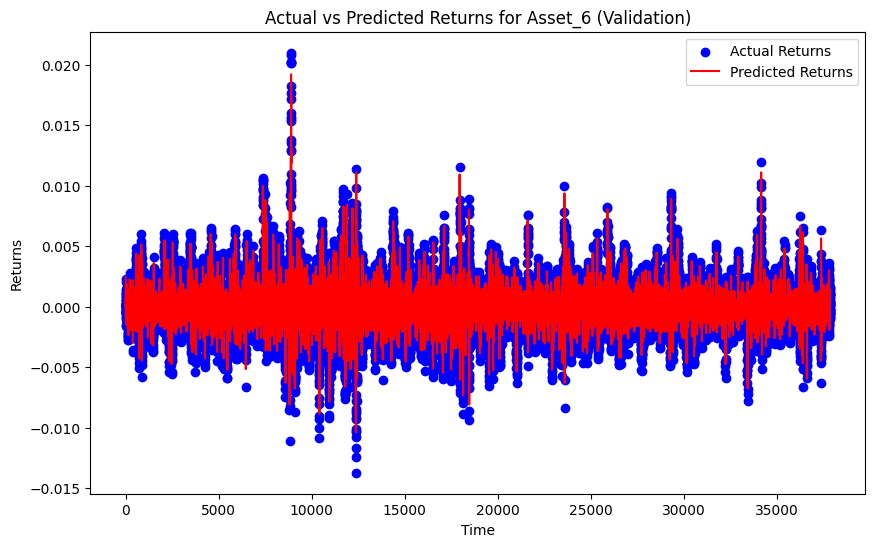

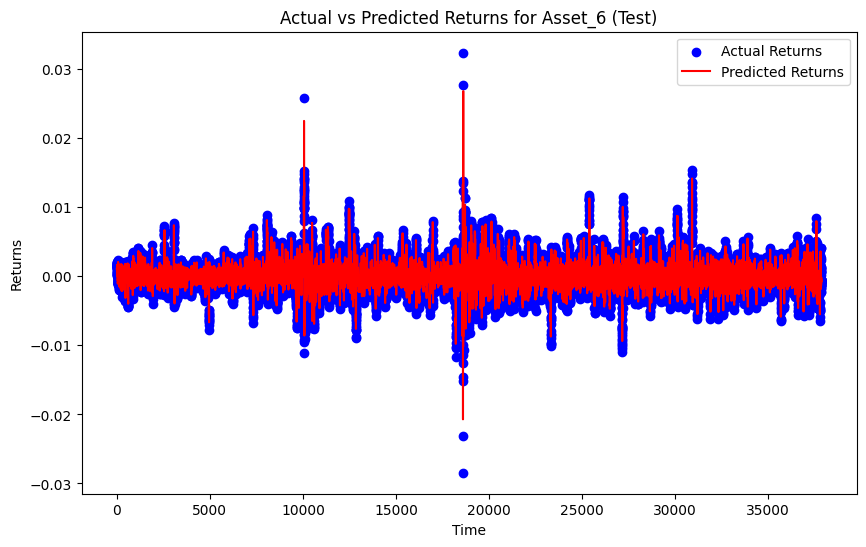

In [145]:
# Plot actual vs predicted returns
def plot_actual_vs_predicted(actual, predicted, asset_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(actual)), actual, label='Actual Returns', color='blue')
    plt.plot(predicted, label='Predicted Returns', color='red')
    plt.title(f'Actual vs Predicted Returns for {asset_name}')
    plt.xlabel('Time')
    plt.ylabel('Returns')
    plt.legend()
    plt.show()

asset_name = f'Asset_{6}' 
actual_train_returns = scaler_y.inverse_transform(y_train.reshape(-1,1))
predicted_train_returns =  scaler_y.inverse_transform(train_predictions)
actual_valid_returns =  scaler_y.inverse_transform(y_valid.reshape(-1,1))
predicted_valid_returns =  scaler_y.inverse_transform(valid_predictions)
actual_test_returns = scaler_y.inverse_transform(y_test.reshape(-1,1))
predicted_test_returns =  scaler_y.inverse_transform(test_predictions)
plot_actual_vs_predicted(actual_train_returns, predicted_train_returns, asset_name + ' (Training)')
plot_actual_vs_predicted(actual_valid_returns, predicted_valid_returns, asset_name + ' (Validation)')
plot_actual_vs_predicted(actual_test_returns, predicted_test_returns, asset_name + ' (Test)')


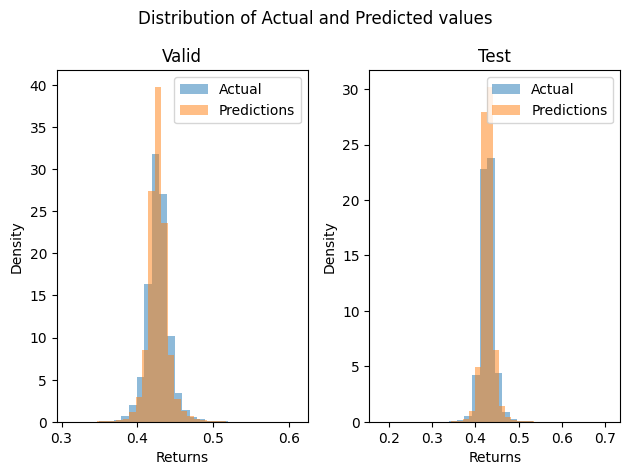

In [146]:
#Distribution of True and Predictions for Valid
plt.subplot(1, 2, 1)
plt.hist(y_valid.flatten(), density=True, bins=30, alpha = 0.5, label="Actual")
plt.hist(valid_predictions, density=True, bins=30, alpha = 0.5, label="Predictions")
plt.title('Valid')
plt.xlabel('Returns')
plt.ylabel('Density')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(y_test.flatten(), density=True, bins=30, alpha = 0.5, label="Actual")
plt.hist(test_predictions, density=True, bins=30, alpha = 0.5, label="Predictions")
plt.title('Test')
plt.xlabel('Returns')
plt.ylabel('Density')
plt.legend()

plt.suptitle("Distribution of Actual and Predicted values")

plt.tight_layout()
plt.show()

In [ ]:
# To calculate Pearson's correlation coefficient
# x=np.corrcoef(actual_valid_returns,predicted_valid_returns)

# Printing the correlation coefficients:
# print(x)